# What do lightcurves look like in the calexps versus the difference images?

## RERUN with DC2 in February 2022
## February 2020 Analysis Sprint

For observations of transients, we can measure the accuracy of the calibration by looking at the "lightcurves" of static objects. There are two questions that we wish to answer: first, how do the magnitudes of stars in individual exposures compare to the magnitudes of the stars in the coadded image catalogs; second, what do we measure using forced photometry at the position of the stars in the difference imaging?

If the calibration could be done perfectly, we would expect to measure the same magnitude for a given star in all calexps and in the coadded image. Similarly, if the subtraction was perfect, we would measure zero flux at the star position in the difference images (assuming no true transient was present nearby). In reality, we aim to have results consistent with the ideal scenario to within error bars. 

~~We will check this with difference imaging produced in `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/ap_pipe_I`, with the forced photometry in `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_src_dir` for the calexps and `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim` for the difference images. For this preliminary analysis, we just look at one patch in COSMOS in the HSC-I band.~~

We will check this with difference imaging produced in the 5 year production from DC2 in tract 4431.

In [1]:
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.geom as geom
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import scipy.stats
import os.path

In [2]:
# This one has 5-year results, but the right catalogs apparently weren't produced:
#butler = Butler('/repo/dc2', collections="u/kherner/2.2i/runs/test20210807-tract4431-w32-step5")
#butler = Butler('/repo/dc2', collections="2.2i/runs/test-med-1/w_2022_03/DM-33223")
butler = Butler('s3://butler-us-central1-panda-dev/dc2/butler-external.yaml', collections='2.2i/runs/test-tract4431/v23_0_0_rc4/PREOPS-912')

In [3]:
# Get the coadded image
tract = 4431
patch = 34
band = 'i'
skymap = 'DC2'

### Get the forced photometry measurements in the coadd:

In [4]:
refCatalog = butler.get('objectTable', patch=patch, tract=tract, skymap=skymap)

In [5]:
len(refCatalog)

39864

### Get the forced photometry measurements in individual calexps and diffims:

In [27]:
# Couldn't load all the columns at once, get around this by breaking into two groups:
columns = ['band', 'psfFlux', 'psfFluxErr', 'ccdVisitId']#, 'psfDiffFlux', 'psfDiffFluxErr', 'objectId']
forced_src = butler.get('forcedSourceTable', tract=tract, skymap=skymap, patch=patch,
                        parameters={"columns": columns})
band_mask = forced_src['band'] == band
forced_src = forced_src[band_mask]
columns2 = ['psfDiffFlux', 'psfDiffFluxErr', 'objectId']
forced_src2 = butler.get('forcedSourceTable', tract=tract, skymap=skymap, patch=patch,
                        parameters={"columns": columns2})
forced_src2 = forced_src2[band_mask]
forced_src = pd.concat([forced_src, forced_src2], axis=1)

In [8]:
len(forced_src)

4629272

### Get seeing information

In [9]:
# Gen3 version:
ccdVisitTable = butler.get('ccdVisitTable')

### Calculate average object fluxes and magnitudes from the calexps and diffims

In [18]:
n = 2000

In [19]:
avg_df = pd.DataFrame(index=refCatalog[::10][:n].index,
                      columns=['refFlux', 'refMag',
                               'calexpFlux', 'calexpFluxStd', 'calexpMag', 'calexpMagStd',
                               'diffFlux', 'diffFluxStd', 'diffMag', 'diffMagStd'])

In [53]:
for r, rc in refCatalog[::10][:n].iterrows():
    rc_match = forced_src[(forced_src['objectId'] == r) & (forced_src['band'] == band)]
    calexp_weight = rc_match['psfFluxErr']**-2
    calexp_avg_flux = np.average(rc_match['psfFlux'], weights=calexp_weight)
    
    calexp_var = np.average((rc_match['psfFlux'] - calexp_avg_flux)**2, weights=calexp_weight)
    calexp_std = calexp_var**0.5
    
    avg_df.loc[r]['calexpFlux'] = calexp_avg_flux
    avg_df.loc[r]['calexpFluxStd'] = calexp_std
    
    diff_weight = rc_match['psfFluxErr']**-2
    diffMask = np.isfinite(rc_match['psfDiffFlux'])
    if diffMask.any():
        diff_avg_flux = np.average(rc_match['psfDiffFlux'][diffMask], weights=rc_match['psfDiffFluxErr'][diffMask]**-2)
        
        diff_var = np.average((rc_match['psfDiffFlux'] - diff_avg_flux)[diffMask]**2, weights=diff_weight[diffMask])
        diff_std = diff_var**0.5

        avg_df.loc[r]['diffFlux'] = diff_avg_flux
        avg_df.loc[r]['diffFluxStd'] = diff_std
        
    ref_mag = (rc[f'{band}_psfFlux'] * u.nJy).to(u.ABmag).to_value()
    if not (rc_match['psfFlux'] < 0).any():
        calexp_mags = (rc_match['psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
        calexp_magWeights = (((np.log(10)/2.5)**2) / (rc_match['psfFluxErr']**-2 * rc_match['psfFlux']**2))**-1
        calexp_avg_mag = np.average(calexp_mags, weights = calexp_magWeights)
        calexp_magvar = np.average((calexp_mags - calexp_avg_mag)**2, weights=calexp_magWeights)
        calexp_magstd = calexp_magvar**0.5
        
        avg_df.loc[r]['calexpMag'] = calexp_avg_mag
        avg_df.loc[r]['calexpMagStd'] = calexp_magstd
    if ((rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux'])[diffMask] > 0).all() and diffMask.any():
        dmags = ((rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux']).to_numpy() * u.nJy).to(u.ABmag).to_value()
        diff_mags = dmags - ref_mag
        diff_magWeights = (((np.log(10)/2.5)**2) / (rc_match['psfDiffFluxErr']**-2 * (rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux'])**2))**-1
        diff_avg_mag = np.average(diff_mags[diffMask], weights = diff_magWeights[diffMask])
    
        diff_magvar = np.average((diff_mags - diff_avg_mag)[diffMask]**2, weights=diff_magWeights[diffMask])
        diff_magstd = diff_magvar**0.5
        avg_df.loc[r]['diffMag'] = diff_avg_mag
        avg_df.loc[r]['diffMagStd'] = diff_magstd
    

    avg_df.loc[r]['refFlux'] = rc[f'{band}_psfFlux']
    
    avg_df.loc[r]['refMag'] = ref_mag
    

# How does the average of the fluxes/magnitudes for an object compare with the coadd flux/magnitude in calexps and diffims?

(15.0, 26.0)

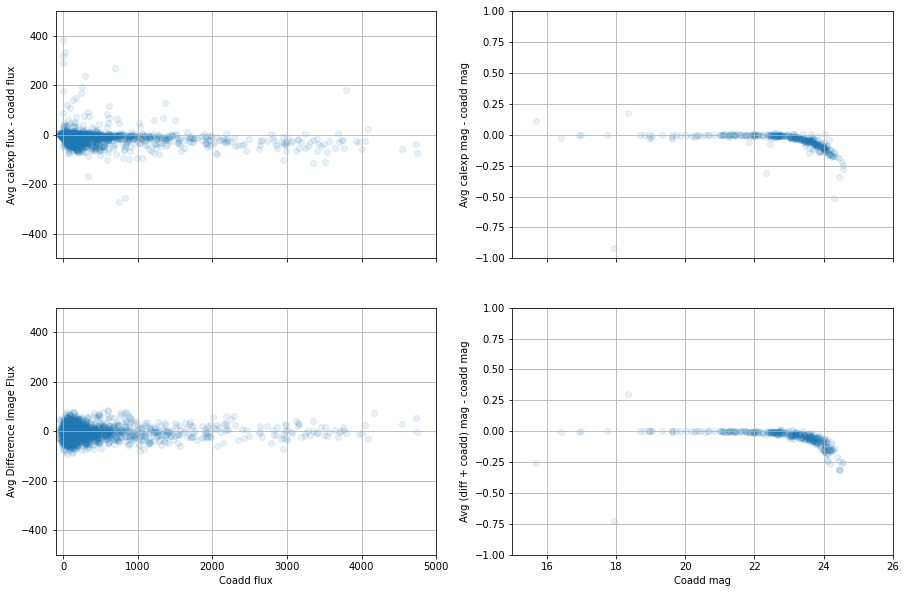

In [54]:
fig, subs = plt.subplots(2,2, figsize=(15,10), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(avg_df['refFlux'], avg_df['calexpFlux'] - avg_df['refFlux'], alpha=0.1)
subs[1,0].scatter(avg_df['refFlux'], avg_df['diffFlux'], alpha=0.1)
subs[0,0].grid(True)
subs[1,0].grid(True)
subs[0,0].set_ylim(-500, 500)
subs[0,0].set_xlim(-100, 5000)
subs[0,0].set_ylabel('Avg calexp flux - coadd flux')
subs[1,0].set_xlabel('Coadd flux')
subs[1,0].set_ylabel('Avg Difference Image Flux')
subs[0,1].scatter(avg_df['refMag'], avg_df['calexpMag'] - avg_df['refMag'], alpha=0.1)
subs[1,1].scatter(avg_df['refMag'], avg_df['diffMag'], alpha=0.1)
subs[0,1].set_ylabel('Avg calexp mag - coadd mag')
subs[0,1].grid(True)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Avg (diff + coadd) mag - coadd mag')
subs[1,1].set_ylim(-1,1)
subs[1,1].grid(True)
subs[0,1].set_xlim(15,26)

## Look at only objects with refExtendedness == 0:

(15.0, 26.0)

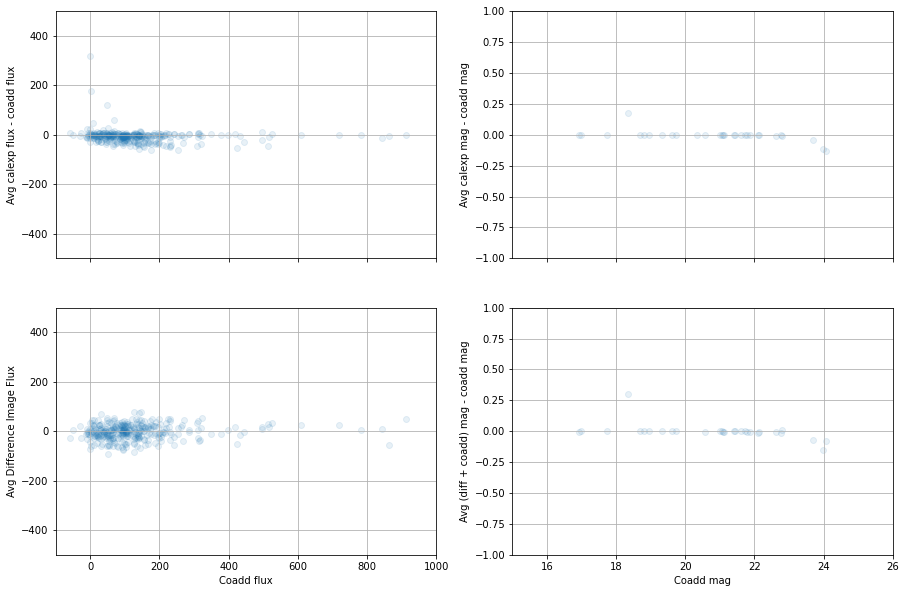

In [55]:
fig, subs = plt.subplots(2,2, figsize=(15,10), sharex='col', sharey='col', facecolor='w')
m = refCatalog[::10][:n]['refExtendedness'] == 0
subs[0,0].scatter(avg_df['refFlux'][m], (avg_df['calexpFlux'] - avg_df['refFlux'])[m], alpha=0.1)
subs[1,0].scatter(avg_df['refFlux'][m], avg_df['diffFlux'][m], alpha=0.1)
subs[0,0].grid(True)
subs[1,0].grid(True)
subs[0,0].set_ylim(-500, 500)
subs[0,0].set_xlim(-100, 1000)
subs[0,0].set_ylabel('Avg calexp flux - coadd flux')
subs[1,0].set_xlabel('Coadd flux')
subs[1,0].set_ylabel('Avg Difference Image Flux')
subs[0,1].scatter(avg_df['refMag'][m], (avg_df['calexpMag'] - avg_df['refMag'])[m], alpha=0.1)
subs[1,1].scatter(avg_df['refMag'][m], avg_df['diffMag'][m], alpha=0.1)
subs[0,1].set_ylabel('Avg calexp mag - coadd mag')
subs[0,1].grid(True)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Avg (diff + coadd) mag - coadd mag')
subs[1,1].set_ylim(-1,1)
subs[1,1].grid(True)
subs[0,1].set_xlim(15,26)

The above plots show that for both the calexps and the diffims, bright stars are on average measured to have the same fluxes and magnitude in the calexps as in the coadds, with flux~0 in the difference images, as would be expected. However, at fainter magnitudes, there is a bias where the average calexp magnitude is brighter than the magnitude in the coadd. In the diffims, there is a bias in the fainter objects towards positive flux measurements. This awaits interpretation.

### Same thing, but using the coadd_meas catalog: don't have this

# How much scatter is there between the calexp fluxes/magnitudes for the same object? Similarly, how much scatter is there between the diffim fluxes/magnitudes for the same object?

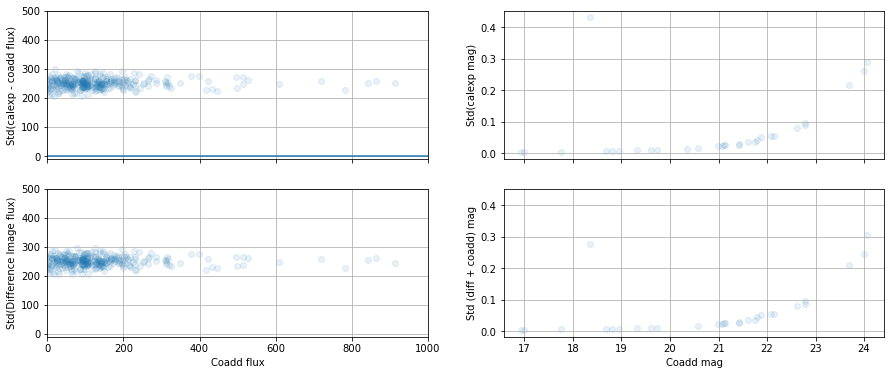

In [56]:
fig, subs = plt.subplots(2, 2, figsize=(15,6), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(avg_df['refFlux'][m], avg_df['calexpFluxStd'][m], alpha=0.1)
subs[0,0].axhline(0)
subs[1,0].set_xlabel('Coadd flux')
subs[0,0].set_ylabel('Std(calexp - coadd flux)')
subs[1,0].set_ylabel('Std(Difference Image flux)')
subs[1,0].scatter(avg_df['refFlux'][m], avg_df['diffFluxStd'][m], alpha=0.1)
subs[0,0].set_xlim(0, 1000)
subs[0,0].set_ylim(-10, 500)
subs[0,0].grid(True)
subs[1,0].grid(True)
subs[0,1].scatter(avg_df['refMag'][m], avg_df['calexpMagStd'][m], alpha=0.1)
subs[0,1].set_ylabel('Std(calexp mag)')
subs[0,1].grid(True)
subs[1,1].scatter(avg_df['refMag'][m], avg_df['diffMagStd'][m], alpha=0.1)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Std (diff + coadd) mag')
subs[1,1].grid(True)
#subs[1,1].set_ylim(-0.01,1.5)

In [25]:
def percentile16(x):
    return np.percentile(x, 16)
def percentile84(x):
    return np.percentile(x, 84)

## Are there systematic differences between observations of the same object at different seeing levels? (objects with extendedness==0 only)
We split up the objects into bins in magnitude, then look at trends in the magnitude residuals in each bin.

75.93366843117104 15.339606304149418
Magnitudes = 15.00 - 17.00, 31 objects


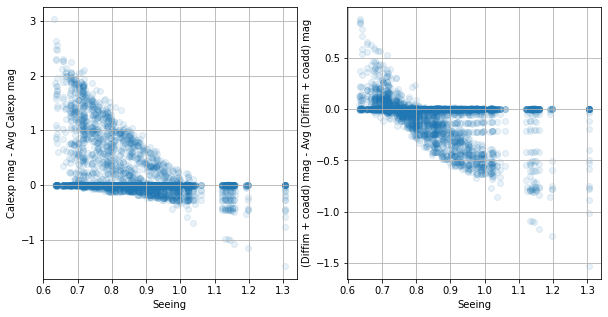

Magnitudes = 17.00 - 19.00, 68 objects


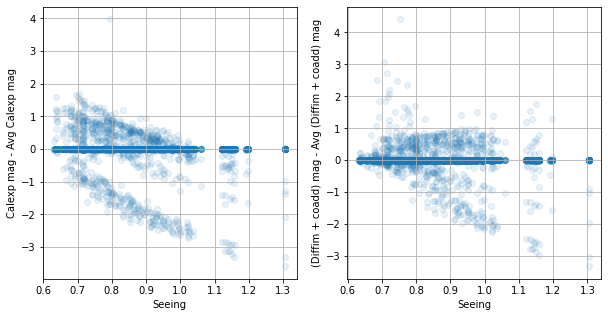

Magnitudes = 19.00 - 21.00, 123 objects


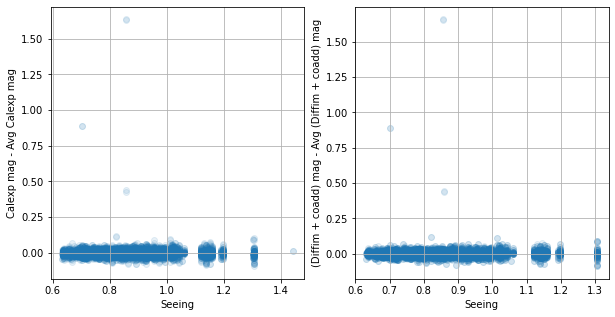

Magnitudes = 21.00 - 23.00, 169 objects


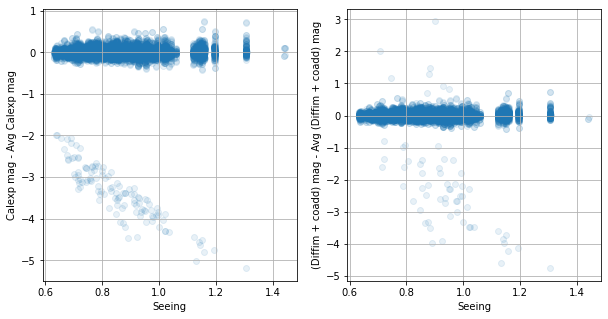

Magnitudes = 23.00 - 25.00, 274 objects


In [ ]:
import warnings
warnings.filterwarnings('ignore')
meas_bins = np.arange(15, 27, 2)
meas_mag = (refCatalog[f'{band}_psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
print(meas_mag[np.isfinite(meas_mag)].max(), meas_mag[np.isfinite(meas_mag)].min())
for mm, m in enumerate(meas_bins[:-1]):
    mm_ind = (meas_mag > meas_bins[mm]) & (meas_mag < meas_bins[mm + 1]) & (refCatalog['refExtendedness'] == 0)
    mm_stars = refCatalog[mm_ind]
    print('Magnitudes = %.2f - %.2f,' % (m, m+2), '%s objects' % len(mm_stars))

    seeings = []
    dmags = []
    diffs = []
    
    for s, star in mm_stars.iterrows():
        rc = star#refCatalog.loc[s]
        if rc['refExtendedness'] != 0:
            continue
        ref_mag = (rc[f'{band}_psfFlux'] * u.nJy).to(u.ABmag).to_value()
        rc_match = forced_src[(forced_src['objectId'] == s) & (forced_src['band'] == band)]
        star_seeing = [ccdVisitTable.loc[rc['ccdVisitId']]['seeing'] for r, rc in rc_match.iterrows()]
        seeings.extend(star_seeing)
        star_mags = (rc_match['psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
        dmags.extend(star_mags - ref_mag)
        star_diffs = ((rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux']).to_numpy() * u.nJy).to(u.ABmag).to_value()
        diffs.extend(star_diffs - ref_mag)
    
    """
    plot_mags = mags[mm_ind]
    plot_ind = np.isfinite(mags[mm_ind]) & (magWeights[mm_ind] != 0) & (mags[mm_ind] != 0)
    plot_diffs = diffMags[mm_ind2]
    plot_diff_ind = np.isfinite(diffMags[mm_ind2]) & (diffMagWeights[mm_ind2] != 0)
    p16 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile16)
    p50 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=np.median)
    p84 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile84)
    """
    fig, subs = plt.subplots(1, 2, figsize=(10, 5))
    subs[0].scatter(seeings, dmags, alpha=0.1)
    subs[1].scatter(seeings, diffs, alpha=0.1)
    """
    subs[0].plot(p16[1][:-1] + 0.5 * np.diff(p16[1])[0], p16[0], linestyle='--', color='r')
    subs[0].plot(p50[1][:-1] + 0.5 * np.diff(p50[1])[0], p50[0], color='r')
    subs[0].plot(p84[1][:-1] + 0.5 * np.diff(p84[1])[0], p84[0], linestyle='--', color='r')
    if mm_ind2.sum() != 0:
        p16_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile16)
        p50_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=np.median)
        p84_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile84)
        subs[1].plot(p16_diff[1][:-1] + 0.5 * np.diff(p16_diff[1])[0], p16_diff[0], linestyle='--', color='r')
        subs[1].plot(p50_diff[1][:-1] + 0.5 * np.diff(p50_diff[1])[0], p50_diff[0], color='r')
        subs[1].plot(p84_diff[1][:-1] + 0.5 * np.diff(p84_diff[1])[0], p84_diff[0], linestyle='--', color='r')
    """
    #subs[0].set_ylim(-0.5, 0.5)
    #subs[1].set_ylim(-0.5, 0.5)
    subs[0].grid(True)
    subs[1].grid(True)
    subs[0].set_xlabel('Seeing')
    subs[1].set_xlabel('Seeing')
    subs[0].set_ylabel('Calexp mag - Avg Calexp mag')
    subs[1].set_ylabel('(Diffim + coadd) mag - Avg (Diffim + coadd) mag')
    plt.show()

## What is the $\chi^2/$dof of the lightcurves?

Assume a model in which the flux is constant. For the diffim lightcurves, the assumed model is a constant flux of zero.

In [29]:
rmags = []
calexp_chis = []
diff_chis = []
for s, star in refCatalog[::10][:n].iterrows():
    if star['refExtendedness'] != 0: continue
    rmags.append(avg_df.loc[s]['refMag'])
    rc_match = forced_src[(forced_src['objectId'] == s) & (forced_src['band'] == band)]
    calexp_chi = ((rc_match['psfFlux'] - avg_df.loc[s]['calexpFlux'])/rc_match['psfFluxErr'])**2
    lc_rchi = calexp_chi.sum() / len(rc_match)
    calexp_chis.append(lc_rchi)
    
    diff_chi = (rc_match['psfDiffFlux']/rc_match['psfDiffFluxErr'])**2
    lc_rchi = diff_chi.sum() / len(rc_match)
    diff_chis.append(lc_rchi)

Text(0.5, 1.0, 'Chi2 of diffim lightcurves (extendedness=0 objects only)')

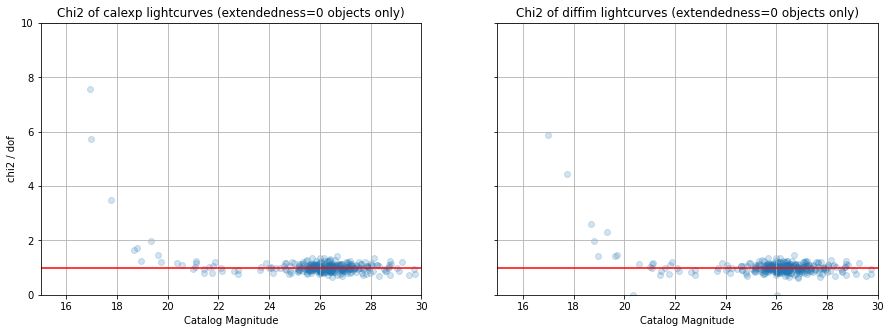

In [30]:
fig, subs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True, facecolor='w')
subs[0].scatter(rmags, calexp_chis, alpha=0.2)
subs[0].set_ylim(0, 10)
subs[0].set_xlim(15, 30)
subs[0].axhline(1, color='r')
subs[0].grid(True)
subs[0].set_ylabel('chi2 / dof')
subs[0].set_xlabel('Catalog Magnitude')
subs[0].set_title('Chi2 of calexp lightcurves (extendedness=0 objects only)')

subs[1].scatter(rmags, diff_chis, alpha=0.2)
subs[1].axhline(1, color='r')
subs[1].grid(True)
subs[1].set_xlabel('Catalog Magnitude')
subs[1].set_title('Chi2 of diffim lightcurves (extendedness=0 objects only)')

# Appendix

### Make some lightcurves of random point source objects

In [31]:
from astropy.time import Time

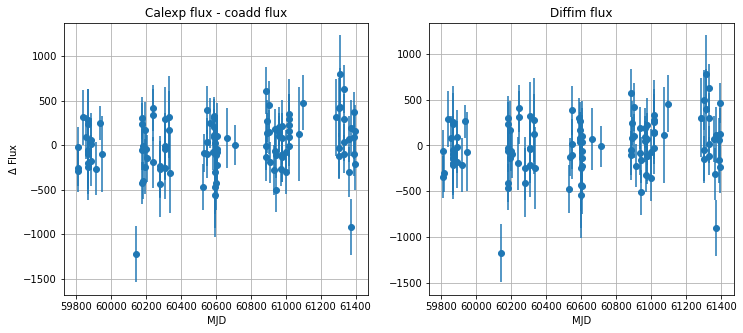

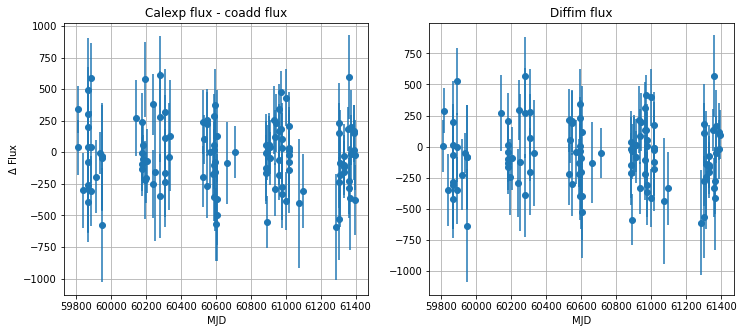

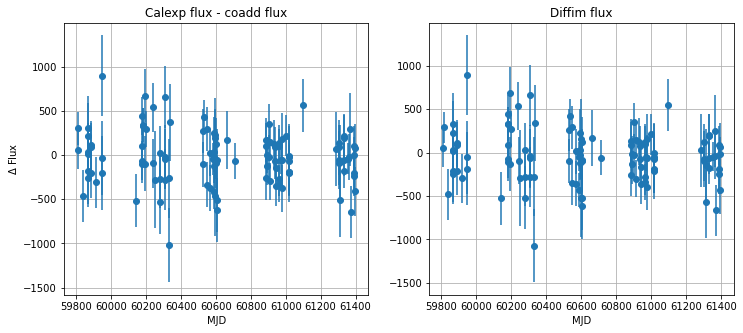

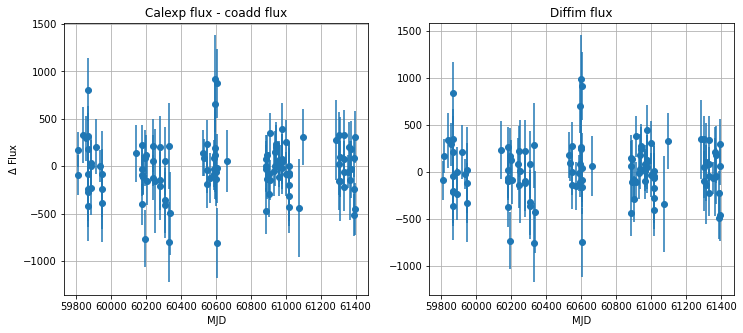

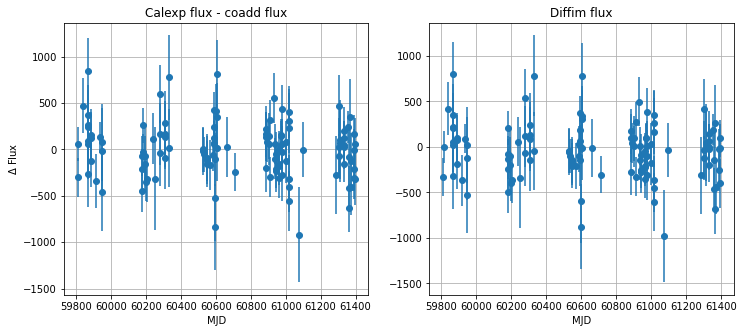

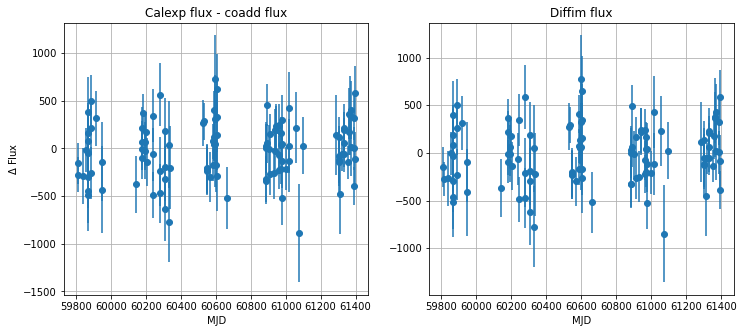

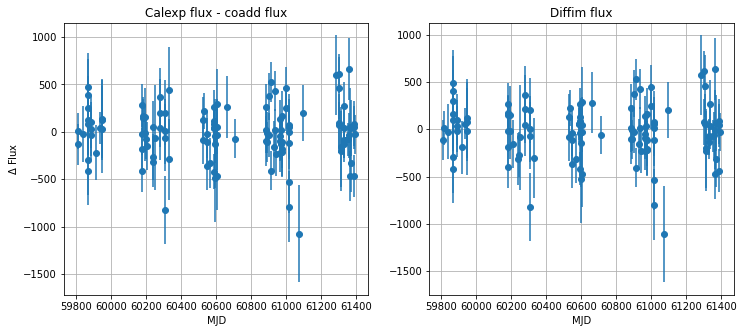

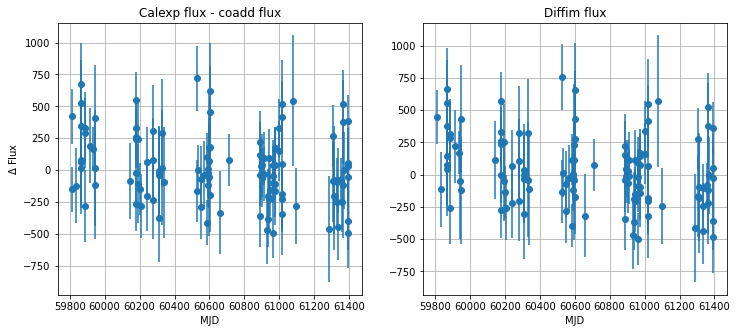

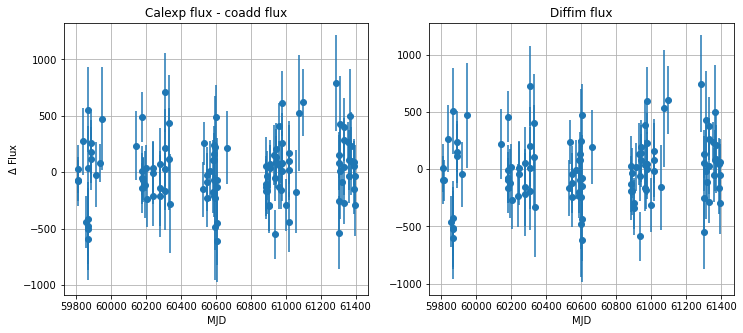

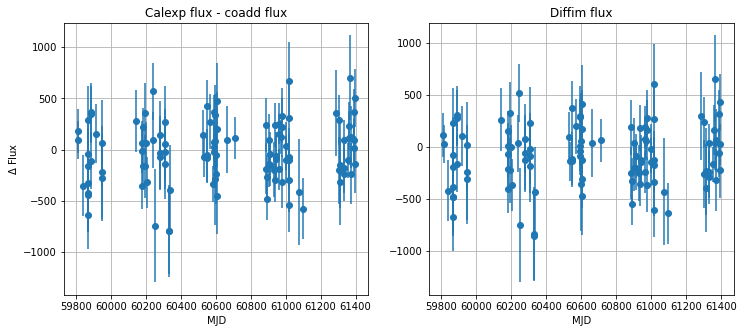

In [43]:
stars = refCatalog[refCatalog['refExtendedness'] == 0]
for s, star in stars[::10][:10].iterrows():
    rc_match = forced_src[(forced_src['objectId'] == s) & (forced_src['band'] == band)]
    obs_time = [Time(ccdVisitTable.loc[rc['ccdVisitId']]['expMidpt']).mjd for r, rc in rc_match.iterrows()]
    fig, subs = plt.subplots(1,2, figsize=(12, 5), sharex=True)
    subs[0].errorbar(obs_time, rc_match['psfFlux'] - star[f'{band}_psfFlux'], yerr = rc_match['psfFluxErr'],
                     linestyle="None", marker='o')
    subs[1].errorbar(obs_time, rc_match['psfDiffFlux'], yerr = rc_match['psfDiffFluxErr'],
                     linestyle="None", marker='o')
    subs[0].grid(True)
    subs[1].grid(True)
    subs[0].set_title('Calexp flux - coadd flux')
    subs[0].set_ylabel('$\Delta$ Flux')
    subs[0].set_xlabel('MJD')
    subs[1].set_title('Diffim flux')
    subs[1].set_xlabel('MJD')

### What do the objects with large scatter in their magnitudes look like?

### Here are some weird ones:

A few of the objects with high scatter in the magnitudes are galaxies, and so variation with seeing is expected. Some of the other objects below are more mysterious:

9
RA = 54.929265273665045 Dec = -31.70262312139384
Mag = 19.615244175658006
Extendedness = 1.0 Blendedness (i) = 0.0


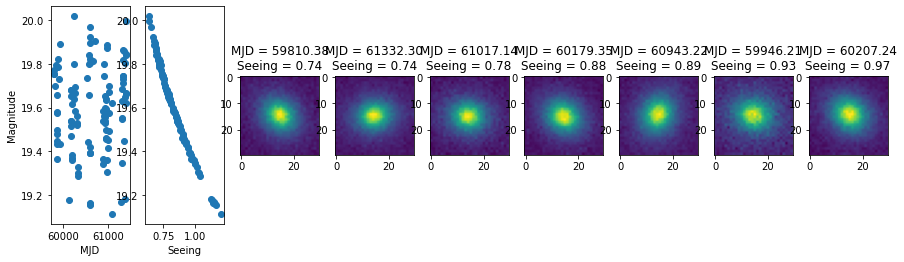

RA = 54.903982812384704 Dec = -31.663784331486514
Mag = 18.357854150953273
Extendedness = 0.0 Blendedness (i) = 0.0


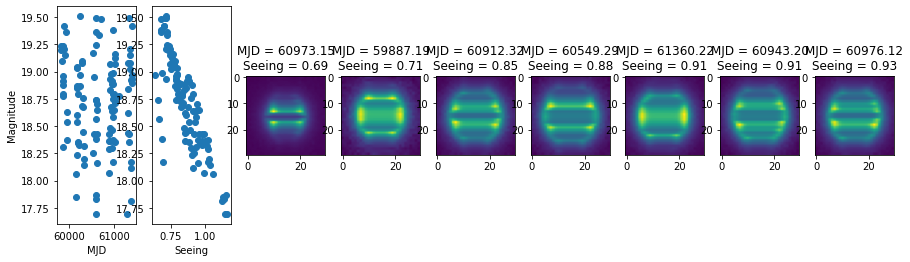

RA = 54.75410179183411 Dec = -31.665801014112567
Mag = 15.695352524064763
Extendedness = 1.0 Blendedness (i) = 0.0


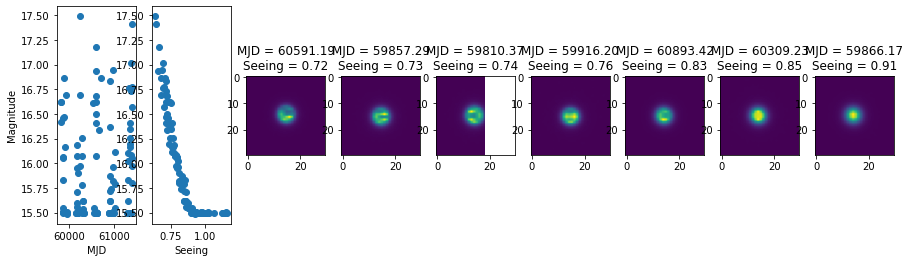

RA = 54.91711504521354 Dec = -31.649021997771136
Mag = 19.027891089484307
Extendedness = 1.0 Blendedness (i) = 0.0


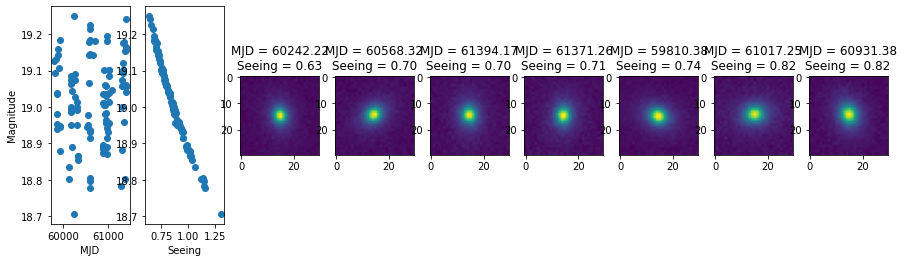

RA = 54.9375891164043 Dec = -31.866139121381156
Mag = 19.009935737661966
Extendedness = 1.0 Blendedness (i) = 0.008677591389209982


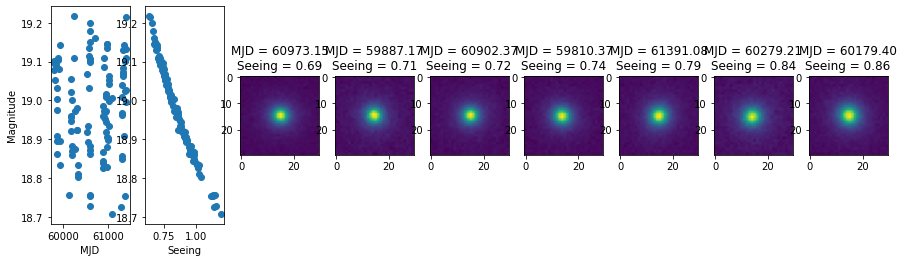

RA = 54.96366068054117 Dec = -31.857145606840227
Mag = 18.955012319575292
Extendedness = 1.0 Blendedness (i) = 0.011186372382471


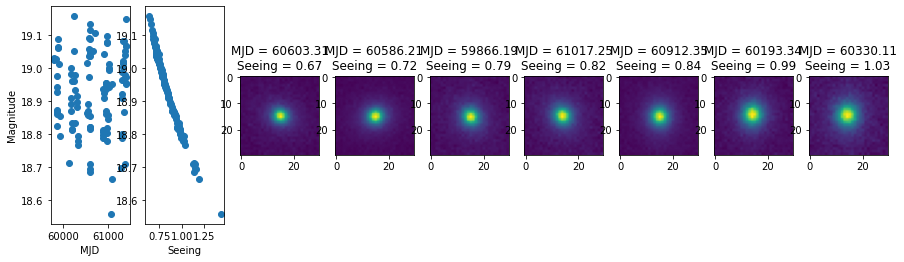

RA = 54.86460614702854 Dec = -31.851432040429195
Mag = 19.615251055778668
Extendedness = 1.0 Blendedness (i) = 0.0046299079795809606


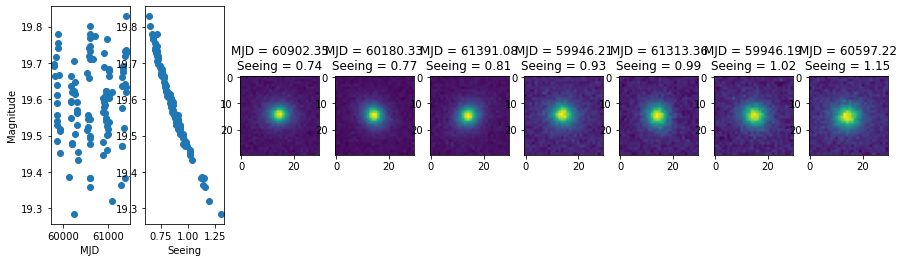

RA = 54.9767663739828 Dec = -31.84739425625693
Mag = 19.84255340801566
Extendedness = nan Blendedness (i) = 0.790165783839189


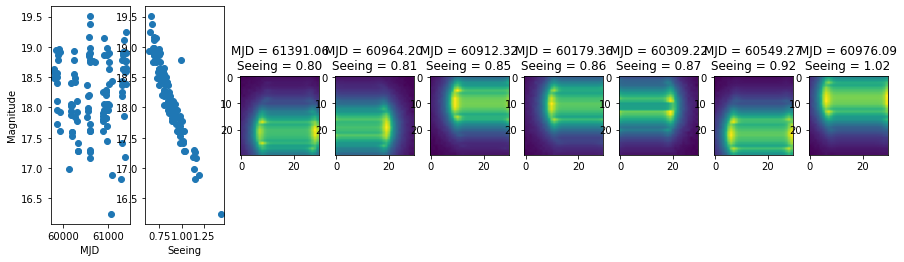

RA = 54.81289352665245 Dec = -31.821825183104362
Mag = 17.945451566929886
Extendedness = nan Blendedness (i) = 0.6271858232497465


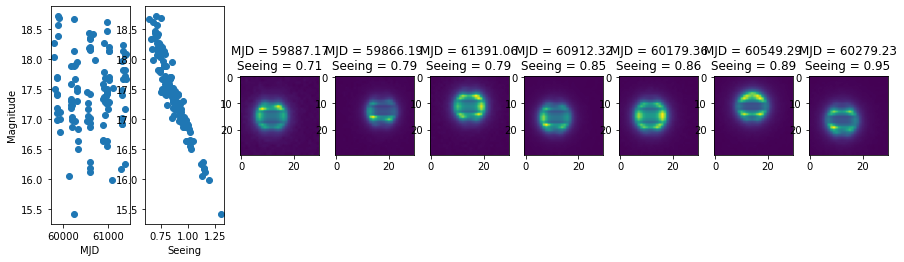

In [38]:
weird_objects = avg_df[(avg_df['refMag'] < 20) & (avg_df['calexpMagStd'] > 0.1)]
print(len(weird_objects))
num_thumbs = 7
for ind, obj in weird_objects[:20].iterrows():
    rc_match = forced_src[(forced_src['objectId'] == ind) & (forced_src['band'] == band)]
    calexp_mags = (rc_match['psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
    ccdvisits = ccdVisitTable.loc[rc_match['ccdVisitId']]
    mjds = Time(ccdvisits['expMidpt']).mjd
    seeings = ccdvisits['seeing'].to_numpy()
    seeing_order = seeings.argsort()
    rCat = refCatalog.loc[ind]
    fig, subs = plt.subplots(1, 2 + num_thumbs, figsize=(15, 4))
    subs[0].scatter(mjds, calexp_mags)
    subs[0].set_xlabel('MJD')
    subs[0].set_ylabel('Magnitude')
    subs[1].scatter(seeings[seeing_order], calexp_mags[seeing_order])
    subs[1].set_xlabel('Seeing')
    print("RA =", rCat['coord_ra'], "Dec =", rCat['coord_dec'])
    print("Mag =", obj['refMag'])
    print("Extendedness =", rCat['refExtendedness'], f"Blendedness ({band}) =", rCat[f'{band}_blendedness'])
    center = geom.SpherePoint(rCat['coord_ra'], rCat['coord_dec'], geom.degrees)
    extent = geom.Extent2I(30, 30)
    i = 2
    random_visit = np.random.choice(len(rc_match), num_thumbs, replace=False)
    random_sort = seeings[random_visit].argsort()
    for c, ccdvisit in ccdvisits.iloc[random_visit[random_sort]].iterrows():
        calexp = butler.get('calexp', tract=tract, band=band, detector=ccdvisit['detector'],
                            visit=ccdvisit['visitId'])
        thumb = calexp.getCutout(center, extent)
        subs[i].imshow(thumb.image.array)
        subs[i].set_title(f"MJD = {Time(ccdvisit['expMidpt']).mjd:.2f}\nSeeing = {ccdvisit['seeing']:.2f}")
        i += 1
        if i == num_thumbs + 2:
            break
    plt.show()

### Some normal ones for comparison:

11
RA = 54.74813215587485 Dec = -31.799981517728053
Mag = 16.933479711904827
Extendedness = 0.0 Blendedness (i) = 0.0


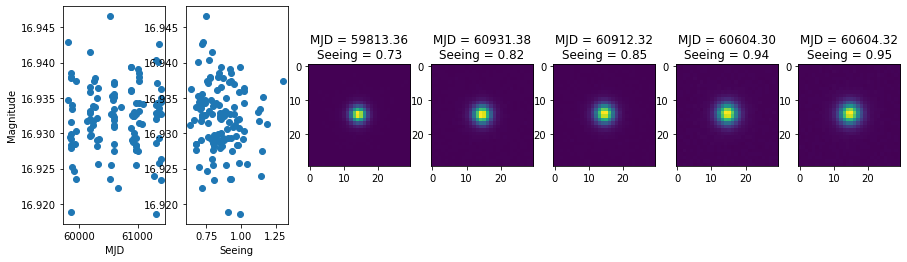

RA = 54.92248042770586 Dec = -31.793302228993625
Mag = 18.796558701683086
Extendedness = 0.0 Blendedness (i) = 0.0


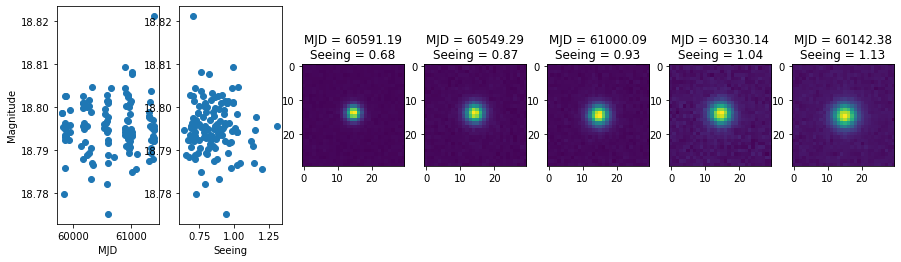

RA = 54.983871946210556 Dec = -31.786812644231233
Mag = 19.617134081474358
Extendedness = 0.0 Blendedness (i) = 0.0


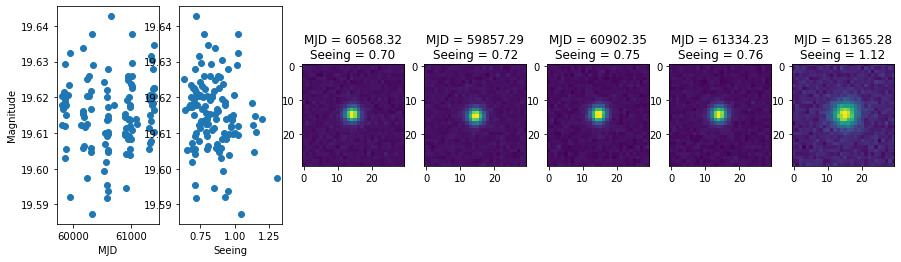

RA = 55.00008620007174 Dec = -31.753557470985662
Mag = 19.329625429651447
Extendedness = 0.0 Blendedness (i) = 0.0


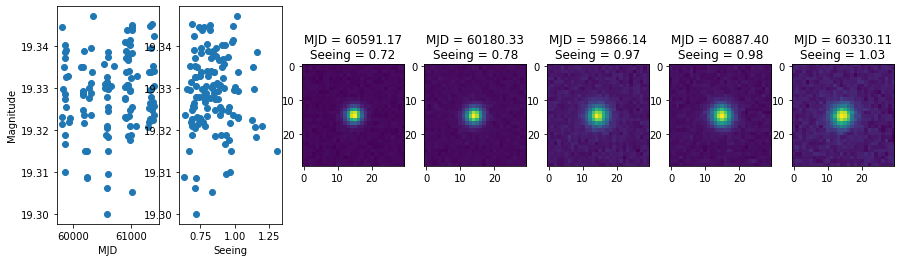

RA = 54.90127622255494 Dec = -31.748137586920933
Mag = 19.85693173147015
Extendedness = 1.0 Blendedness (i) = 0.0


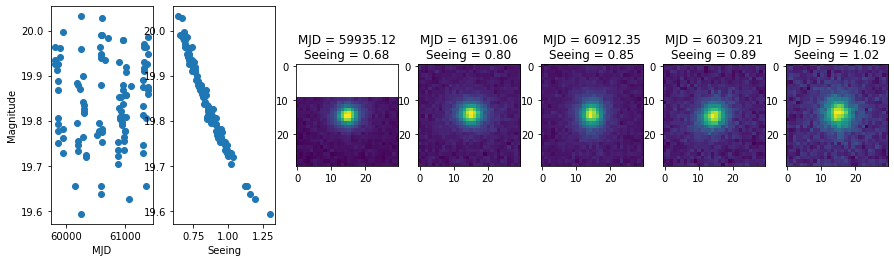

In [40]:
normal_objects = avg_df[(avg_df['refMag'] < 20) & (avg_df['calexpMagStd'] < 0.1)]
print(len(normal_objects))
num_thumbs = 5
for ind, obj in normal_objects[:5].iterrows():
    rc_match = forced_src[(forced_src['objectId'] == ind) & (forced_src['band'] == band)]
    calexp_mags = (rc_match['psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
    ccdvisits = ccdVisitTable.loc[rc_match['ccdVisitId']]
    mjds = Time(ccdvisits['expMidpt']).mjd
    seeings = ccdvisits['seeing'].to_numpy()
    seeing_order = seeings.argsort()
    rCat = refCatalog.loc[ind]
    fig, subs = plt.subplots(1, 2 + num_thumbs, figsize=(15, 4))
    subs[0].scatter(mjds, calexp_mags)
    subs[0].set_xlabel('MJD')
    subs[0].set_ylabel('Magnitude')
    subs[1].scatter(seeings[seeing_order], calexp_mags[seeing_order])
    subs[1].set_xlabel('Seeing')
    print('RA =', rCat['coord_ra'], 'Dec =', rCat['coord_dec'])
    print("Mag =", obj['refMag'])
    print("Extendedness =", rCat['refExtendedness'], f"Blendedness ({band}) =", rCat[f'{band}_blendedness'])
    center = geom.SpherePoint(rCat['coord_ra'], rCat['coord_dec'], geom.degrees)
    extent = geom.Extent2I(30, 30)
    i = 2
    random_visit = np.random.choice(len(rc_match), num_thumbs, replace=False)
    random_sort = seeings[random_visit].argsort()
    for c, ccdvisit in ccdvisits.iloc[random_visit[random_sort]].iterrows():
        calexp = butler.get('calexp', tract=tract, band=band, detector=ccdvisit['detector'],
                            visit=ccdvisit['visitId'])
        thumb = calexp.getCutout(center, extent)
        subs[i].imshow(thumb.image.array)
        subs[i].set_title(f"MJD = {Time(ccdvisit['expMidpt']).mjd:.2f}\nSeeing = {ccdvisit['seeing']:.2f}")
        i += 1
        if i == 7:
            break
    plt.show()

### What is the range of blendedness values?

In [ ]:
plt.hist(refCatalog[f'{band}_blendedness']);

### What is the range of extendedness values?

In [ ]:
plt.hist(refCatalog['refExtendedness'])